In [13]:
import cv2
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

import scipy.stats as ss

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

from PIL import Image, ImageDraw, ImageFont
import PIL

import os

import copy
import random
import time

%matplotlib inline

In [14]:
from google.colab import drive
drive.mount('./data')

Drive already mounted at ./data; to attempt to forcibly remount, call drive.mount("./data", force_remount=True).


In [15]:
PREFIX = "data/MyDrive/Colab Notebooks/Doc_recognition/Passports/"

In [16]:
data = pd.read_csv(PREFIX + "dataset/Passports.csv")
data.head()

,Unnamed: 0,file_name,H,W,channels,dep,p_date,code,surname,name,...,b_place3-right-x,b_place3-right-y,up-left-x,up-left-y,up-right-x,up-right-y,bottom-left-x,bottom-left-y,bottom-right-x,bottom-right-y
0,0,passport0.jpg,731,522,3,ОТДЕЛОМ УФМС РОССИИ ПО КАЛУЖСКОЙ ОБЛ. В МАЛОЯР...,22.09.2014,400-017,ИЗМАЙЛОВ,РУСТАМ,...,470,615,22,430,168,430,22,618,168,618
1,1,passport1.jpg,731,522,3,ОКТЯБРЬСКИМ РУВД Г. ТАМБОВА,07.11.2018,682-016,ФИЛАТОВ,ПЛАТОН,...,470,615,22,430,168,430,22,618,168,618
2,2,passport2.jpg,731,522,3,ГУ МВД РОССИИ ПО РОСТОВСКОЙ ОБЛ.,01.01.2022,610-030,ТАРАСОВ,АЛЬБЕРТ,...,470,615,22,430,168,430,22,618,168,618
3,3,passport3.jpg,731,522,3,ОВД ДИГОРСКОГО РАЙОНА РЕСП. СЕВЕРНАЯ ОСЕТИЯ-АЛ...,05.07.2017,152-007,ФИЛАТОВ,КИРИЛЛ,...,470,615,22,430,168,430,22,618,168,618
4,4,passport4.jpg,731,522,3,УСПЕНСКИМ ПОСЕЛКОВЫМ ОМ ОДИНЦОВСКОГО РАЙОНА МО...,26.12.2019,503-068,КАРПОВ,ВЛАДИМИР,...,470,615,22,430,168,430,22,618,168,618


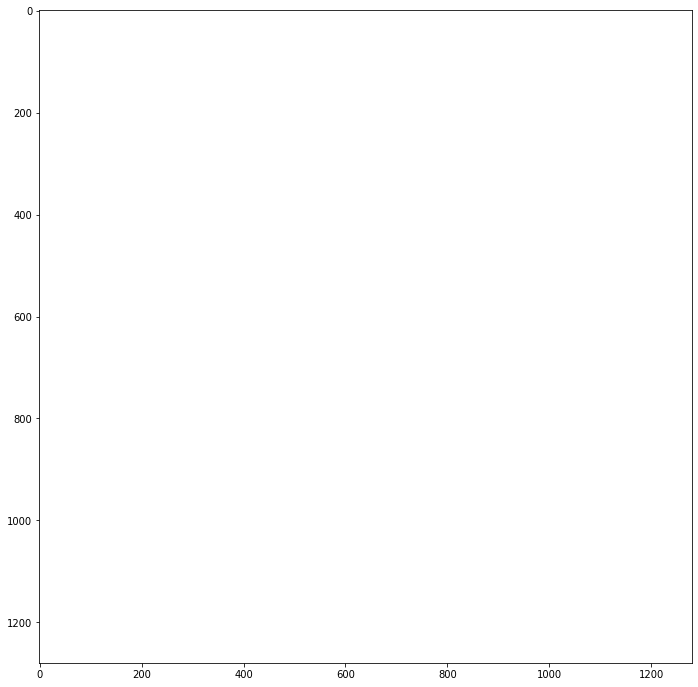

In [17]:
backgrounds = os.listdir(PREFIX + "photo_data/backgrounds")
backs = []

for bg in backgrounds:
    backs.append(PIL.Image.open(PREFIX + "photo_data/backgrounds/" + bg))
    size_0 = backs[-1].size

    backs[-1] = backs[-1].resize((size_0[0], size_0[0]))

ind = np.random.randint(len(backgrounds))
plt.figure(figsize=(12, 12))
plt.imshow(backs[ind])

(900, 900)

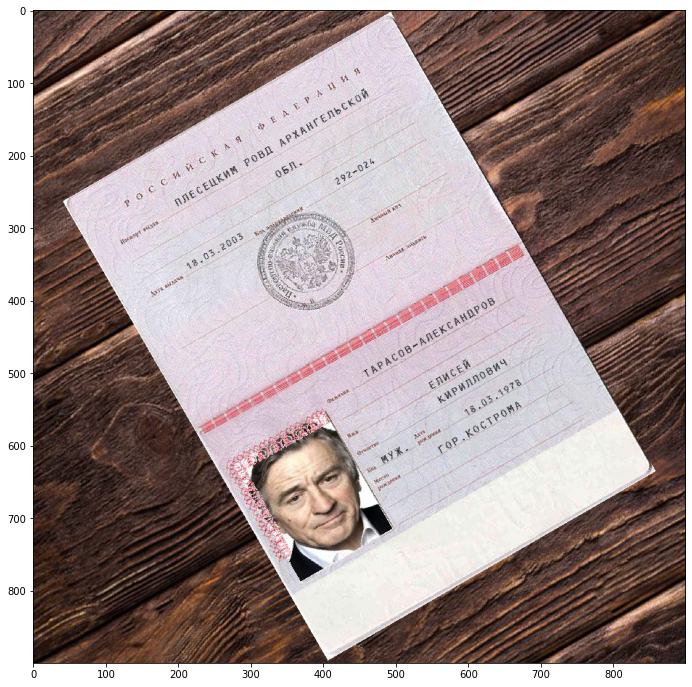

In [18]:
def crop_rotate(background, image, alpha, output_size=None):
    """
    Pastes an image onto the background, 
    rotates it and crops to leave no black pixels in corners.
    Background (NxN image) - has to be big enough for this operation
    """
    alpha_rad = alpha / 180 * np.pi
    back = background.copy()
    img = image.copy()

    back.paste(img, ((back.size[0] - img.size[0]) // 2, (back.size[1] - img.size[1]) // 2))
    back = back.rotate(alpha)

    a = np.ceil(np.sqrt(image.size[0] ** 2 + image.size[1] ** 2))
    b = (background.size[0] - a) // 2
    back = back.crop((b, b, b + a + 1, b + a + 1))
    return back

  
passport = PIL.Image.open(PREFIX + f"dataset/images/passport{np.random.randint(1000)}.jpg")
rotated = crop_rotate(backs[0], passport, 30)
plt.figure(figsize=(12, 12))
plt.imshow(rotated)
rotated.size

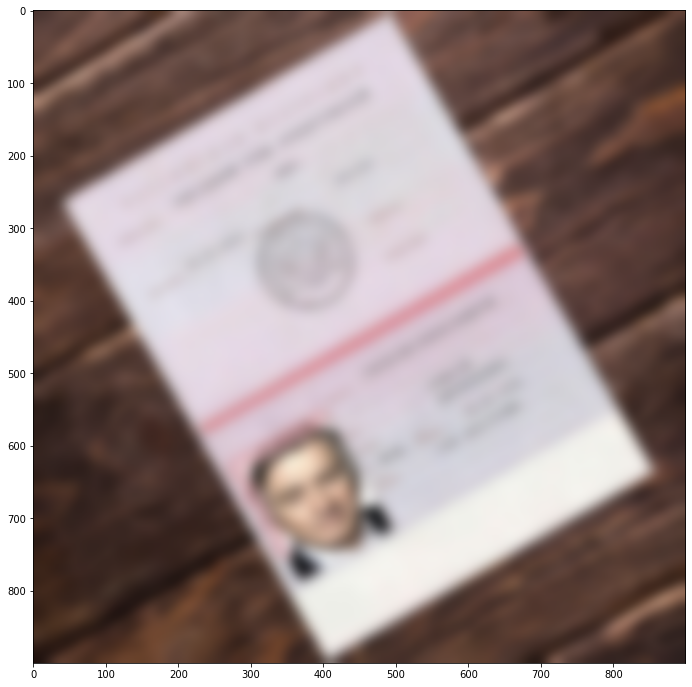

In [19]:
rotated_np = np.array(rotated)
blur = cv2.GaussianBlur(rotated_np, (55, 55), 0)
blurred = PIL.Image.fromarray(blur)

plt.figure(figsize=(12, 12))
plt.imshow(blurred)

In [20]:
images = os.listdir(PREFIX + "dataset/images")
np.random.shuffle(images)

RATIO = 0.9
train_inds = np.array([900])
valid_inds = np.array([901, 1000])

In [21]:
class Generator:
    def crop_rotate(background, image, alpha, output_size=None):
        """
        Pastes an image onto the background, 
        rotates it and crops to leave no black pixels in corners.
        Background (NxN image) - has to be big enough for this operation
        """
        alpha_rad = alpha / 180 * np.pi
        back = background.copy()
        img = image.copy()

        back.paste(img, ((back.size[0] - img.size[0]) // 2, (back.size[1] - img.size[1]) // 2))
        back = back.rotate(alpha)

        a = np.ceil(np.sqrt(image.size[0] ** 2 + image.size[1] ** 2))
        b = (background.size[0] - a) // 2
        back = back.crop((b, b, b + a + 1, b + a + 1))
        return back

    def transform(image_path, background, alpha, size, blur=0):
        img = PIL.Image.open(image_path)
        img = Generator.crop_rotate(background, img, alpha=alpha).resize((size, size))
        np_img = np.array(img)
        if blur:
            np_img = cv2.GaussianBlur(np_img, (blur, blur), 0)
        return np.array([
            np_img[:, :, 0].reshape(np_img.shape[0], np_img.shape[1]), 
            np_img[:, :, 1].reshape(np_img.shape[0], np_img.shape[1]), 
            np_img[:, :, 2].reshape(np_img.shape[0], np_img.shape[1])
        ])

    def generate_batch(backgrounds, images, batch_size=32, n_classes=10, model_type='classifier', min_bound=-90, max_bound=90, size=224, blur=0):
        if model_type == 'classifier':
            angles = np.linspace(min_bound, max_bound, n_classes)
        else:
            angles = np.arange(min_bound, max_bound)
        for n in range(len(images) // batch_size if len(images) % batch_size == 0 else len(images) // batch_size + 1):
            batch_x = []
            batch_y = []
            for i in range(min(batch_size, len(images) - n * batch_size)):
                y = np.random.randint(len(angles))
                alpha = angles[y]
                batch_x.append(Generator.transform(PREFIX + "dataset/images/" + images[batch_size * n + i], np.random.choice(backgrounds), alpha, size, blur=blur))
                batch_y.append(y if model_type == "classifier" else alpha)
            batch_x = torch.from_numpy(np.array(batch_x)).type(torch.FloatTensor)
            batch_y = torch.tensor(batch_y).type(torch.LongTensor)
            yield batch_x, batch_y

    def __init__(self, backgrounds, images, n_classes=10, batch_size=32, model_type='classifier', min_bound=-30, max_bound=30, size=224, blur=0):
        self.len = len(images) // batch_size if len(images) % batch_size == 0 else len(images) // batch_size + 1
        self.gen = Generator.generate_batch(backgrounds, images, batch_size, n_classes, model_type, min_bound, max_bound, size, blur)

    def __len__(self):
        return self.len

    def __next__(self):
        return next(self.gen)

    def __iter__(self):
        return self.gen

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Собственно, регрессия

In [25]:
def train(model, gen, optimizer, criterion, device, augmentator=None):
    torch.manual_seed(1337)
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for x, y in tqdm(gen, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred.type(torch.FloatTensor), y.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(gen)

In [26]:
def evaluate(model, gen, criterion, device, augmentator=None):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for x, y in tqdm(gen, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred.type(torch.FloatTensor), y.type(torch.FloatTensor))

            epoch_loss += loss.item()

    return epoch_loss / len(gen)

In [44]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 3 * 3, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(3 * 3, 9 * 3, kernel_size=9, stride=5, padding=4),
            nn.ReLU(inplace=True),
        )
        self.linear_block = nn.Sequential(
            nn.Linear(9 * 3 * 68 * 68, 1),
        )
                
    def forward(self, x):
        x = (x - x.mean(axis=0)) / x.std(axis=0)
        x = self.conv_block(x)
        x = x.view(-1, 9 * 3 * 68 * 68)
        x = self.linear_block(x)
        return x

In [45]:
loss_storage = {}

In [46]:
regressor = CNNRegressor()

optimizer = optim.Adam(params=regressor.parameters(), lr=0.001)
# optimizer = optim.SGD(params=regressor.parameters(), lr=0.00001, momentum=0.5)
criterion = nn.L1Loss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
EPOCHS = 15

device = 'cuda' if torch.cuda.is_available() else 'cpu'

best_valid_loss = float('inf')
validation_loss = []

for epoch in range(EPOCHS):
    train_gen = Generator(backs, images[:300], n_classes=36, batch_size=16, model_type='regressor', size=336, min_bound=-30, max_bound=30, blur=0)
    valid_gen = Generator(backs, images[300:500], n_classes=36, batch_size=16, model_type='regressor', size=336, min_bound=-30, max_bound=30, blur=0)
    start_time = time.monotonic()

    train_loss = train(regressor, train_gen, optimizer, criterion, device)
    valid_loss = evaluate(regressor, valid_gen, criterion, device)
    validation_loss.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(regressor.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Training:   0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-21-b5fcf5b8c90c>:43: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  batch_x.append(Generator.transform(PREFIX + "dataset/images/" + images[batch_size * n + i], np.random.choice(backgrounds), alpha, size, blur=blur))
<ipython-input-21-b5fcf5b8c90c>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_x.append(Generator.transform(PREFIX + "dataset/image

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 3s
	Train Loss: 14.347
	 Val. Loss: 15.971


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 57s
	Train Loss: 14.959
	 Val. Loss: 14.615


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 58s
	Train Loss: 14.942
	 Val. Loss: 15.048


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 57s
	Train Loss: 13.975
	 Val. Loss: 15.971


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 56s
	Train Loss: 14.687
	 Val. Loss: 14.750


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 57s
	Train Loss: 14.518
	 Val. Loss: 15.380


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 56s
	Train Loss: 14.599
	 Val. Loss: 14.995


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
loss_storage["Increasing angle"] = validation_loss.copy()

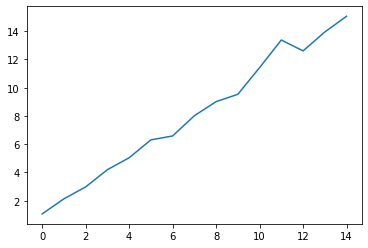

In [ ]:
plt.plot(np.arange(15), loss_storage["Increasing angle"])

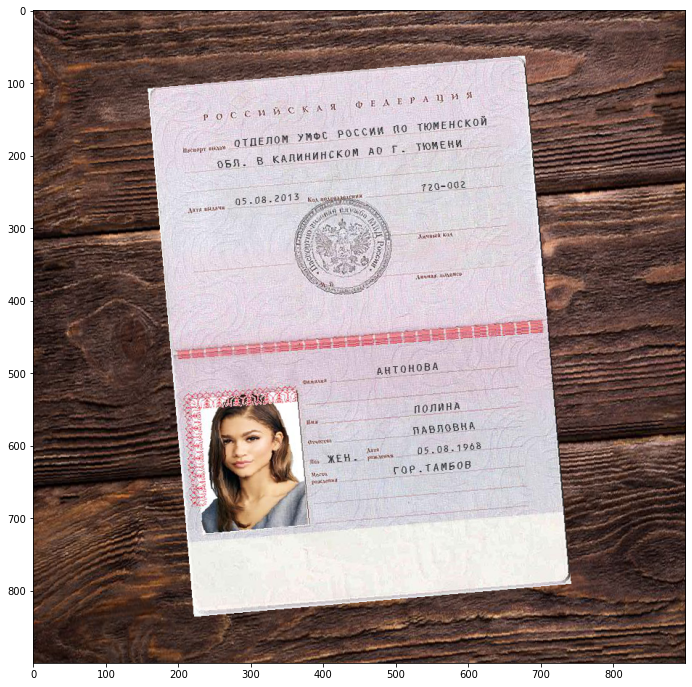

In [ ]:
passport = PIL.Image.open(PREFIX + f"dataset/images/passport{np.random.randint(1000)}.jpg")
rotated = crop_rotate(backs[0], passport, 5)
plt.figure(figsize=(12, 12))
plt.imshow(rotated)

rotated = rotated.resize((336, 336))
rotated = np.array(rotated)

In [ ]:
rotated_np = np.array([[
                    rotated[:, :, 0].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 1].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 2].reshape(rotated.shape[0], rotated.shape[1])
                ]])
x_test = torch.from_numpy(rotated_np).type(torch.FloatTensor)
regressor(x_test)

tensor([[-0.3802]], grad_fn=<AddmmBackward0>)

## MobileNet

In [ ]:
from torchvision.models.mobilenet import mobilenet_v2

In [ ]:
mobile_net = mobilenet_v2(pretrained=True)
mobile_net.classifier[1] = torch.nn.Linear(in_features=mobile_net.classifier[1].in_features, out_features=1)

optimizer = optim.Adam(params=mobile_net.parameters(), lr=0.003)
criterion = nn.MSELoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
mobile_net.eval()
mobile_net = mobile_net.to(device)
criterion = criterion.to(device)

In [ ]:
EPOCHS = 15

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    train_gen = Generator(backs, images[:300], n_classes=60, batch_size=32, model_type='regressor', size=224)
    valid_gen = Generator(backs, images[300:400], n_classes=60, batch_size=32, model_type='regressor', size=224)
    start_time = time.monotonic()

    train_loss = train(
        mobile_net, 
        train_gen, 
        optimizer, 
        criterion, 
        device
    )
    
    valid_loss = evaluate(
        mobile_net, 
        valid_gen, 
        criterion, 
        device
    )

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(mobile_net.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Training:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-8-65d202e58998>:14: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  img = crop_rotate(np.random.choice(backgrounds), img, alpha=alpha).resize((size, size))
<ipython-input-8-65d202e58998>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img = crop_rotate(np.random.choice(backgrounds), img, alpha=alpha).resize((size, size))
/usr/local/lib/python3.8/dist-pa

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 28s
	Train Loss: 295.164
	 Val. Loss: 235.984


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 27s
	Train Loss: 287.224
	 Val. Loss: 429.425


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 22s
	Train Loss: 307.154
	 Val. Loss: 293.688


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 21s
	Train Loss: 314.172
	 Val. Loss: 384.744


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 22s
	Train Loss: 309.010
	 Val. Loss: 306.759


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 21s
	Train Loss: 296.728
	 Val. Loss: 243.042


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 21s
	Train Loss: 296.428
	 Val. Loss: 324.276


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 22s
	Train Loss: 304.194
	 Val. Loss: 277.844


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 21s
	Train Loss: 281.858
	 Val. Loss: 268.654


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 22s
	Train Loss: 311.481
	 Val. Loss: 382.787


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 1m 22s
	Train Loss: 277.227
	 Val. Loss: 351.722


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 1m 21s
	Train Loss: 284.649
	 Val. Loss: 278.530


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 1m 21s
	Train Loss: 323.453
	 Val. Loss: 283.946


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 1m 22s
	Train Loss: 307.784
	 Val. Loss: 322.788


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 1m 21s
	Train Loss: 303.568
	 Val. Loss: 273.260


In [ ]:
rotated_np = np.array([[
                    rotated[:, :, 0].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 1].reshape(rotated.shape[0], rotated.shape[1]), 
                    rotated[:, :, 2].reshape(rotated.shape[0], rotated.shape[1])
                ]])
x_test = torch.from_numpy(rotated_np).type(torch.FloatTensor)
mobile_net(x_test)

tensor([[-3.2022]], grad_fn=<AddmmBackward0>)